<a href="https://colab.research.google.com/github/habhishek/GenerativeModelSamples/blob/main/bayesian_classifier_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/habhishek/deep_nn_dev

Cloning into 'deep_nn_dev'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 43 (delta 9), reused 32 (delta 6), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [2]:
import h5py
import numpy as np
import pandas as pd
import pickle
import gzip

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def load_data():
    train_dataset = h5py.File('deep_nn_dev/data/train.hdf5', "r")
    train_set_x_orig = np.array(train_dataset["image"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["label"][:]) # your train set labels

    test_dataset = h5py.File('deep_nn_dev/data/test.hdf5', "r")
    test_set_x_orig = np.array(test_dataset["image"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["label"][:]) # your test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [5]:
x_train_orig, y_train_orig, _ , _ = load_data()

In [6]:
y_train_orig.shape

(1, 60000)

In [7]:
x_train = np.reshape(x_train_orig, (60000, 784))/255.0
y_train = np.reshape(y_train_orig, (60000,))


In [8]:
x_train.shape

(60000, 784)

In [9]:
x_train[y_train == 2].shape

(5958, 784)

In [10]:
from scipy.stats import multivariate_normal as mvn

In [11]:
class BayesClassifier():
  def fit(self, X, Y):
    # for each unique class in Y, find the correspoinding data and calculate
    # mean and covariance of the datapoint - results into a gaussian distribution
    # parameters for each class

    # no of unique class
    self.K = len(set(Y))

    self.gaussians = [] # empty dictionary to save gaussian params for each class
    self.p_y = np.zeros(self.K) # to record the probability of each unique class in the dataset
    for k in range(self.K):
      # find the data corresponding to the class k
      Xk = X[Y == k] # Y == k is a boolean array with indices having True value where class Y = k
      m_k = Xk.mean(axis=0) # mean of all Xk
      cov_k = np.cov(Xk.T) # transpose because the input data pattern for np.cov
                           # is every row is a feature and every column is 
                           # single observation of the variable
      g = {'m': m_k, 'c': cov_k}
      self.p_y[k] = len(Xk)/len(X) # probability of class k in Y is given by
                                   # no of data for k / total no of data
      self.gaussians.append(g)
  
  def sample_given_y(self, k):
    g = self.gaussians[k]
    return mvn.rvs(mean = g['m'], cov = g['c'])
  
  def sample(self):
    k = np.random.choice(self.K, p=self.p_y) # choose a class k randomdly using
                                             # using the prob distbn p_y
    return self.sample_given_y(k)


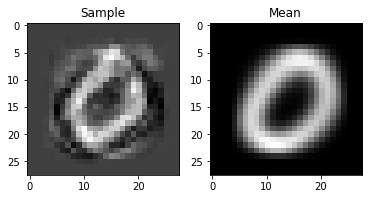

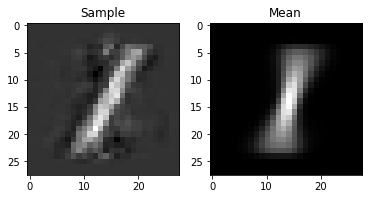

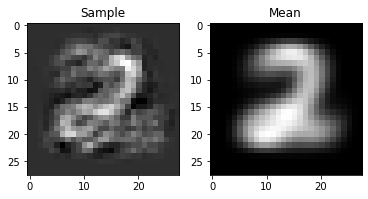

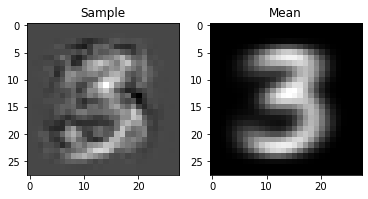

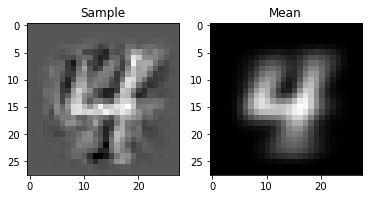

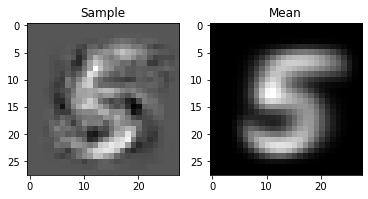

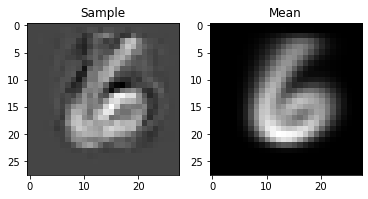

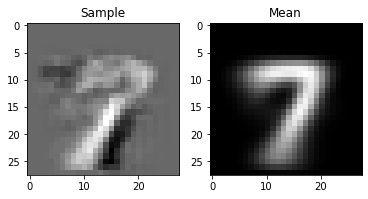

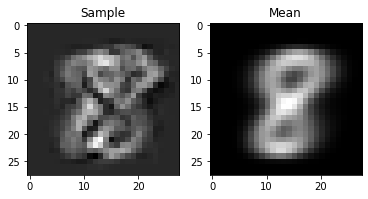

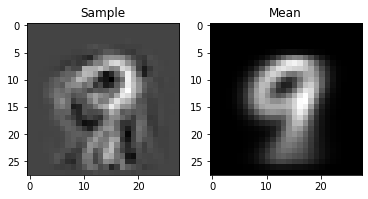

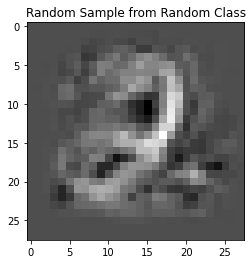

In [12]:
clf = BayesClassifier()
clf.fit(x_train, y_train)

for k in range(clf.K):
  # show one sample for each class
  # also show the mean image learned

  sample = clf.sample_given_y(k).reshape(28, 28)
  mean = clf.gaussians[k]['m'].reshape(28, 28)

  plt.subplot(1,2,1)
  plt.imshow(sample, cmap='gray')
  plt.title("Sample")
  plt.subplot(1,2,2)
  plt.imshow(mean, cmap='gray')
  plt.title("Mean")
  plt.show()

# generate a random sample
sample = clf.sample().reshape(28, 28)
plt.imshow(sample, cmap='gray')
plt.title("Random Sample from Random Class")
plt.show()

### TODO: Explain What Happened Here

In [13]:
from sklearn.mixture import BayesianGaussianMixture

In [23]:
class BayesianGMM():
  def fit(self, X, Y):
    self.K = len(set(Y))
    self.gaussians = []
    self.p_y = np.zeros(self.K)

    for k in range(self.K):
      Xk = X[Y==k]
      gmm = BayesianGaussianMixture(10)
      g = gmm.fit(Xk)
      p_y_k = len(Xk)/len(X)
      self.gaussians.append(g)
      self.p_y[k] = len(Xk)/len(X)
  
  def sample_given_y(self, k):
    gmm = self.gaussians[k]
    sample = gmm.sample()
    # note: gmm.sample() returns 2 values
    # 1 is the sample
    # 2 is the cluster from which it has come
    # we also return the mean of data from this cluster using
    # BayesianGaussianMixture.mean_(cluster) 
    return sample[0].reshape((28,28)), gmm.means_[sample[1]].reshape((28,28))
  
  def sample(self):
    k = np.random.choice(self.K, p=self.p_y)
    return self.sample_given_y(k)


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


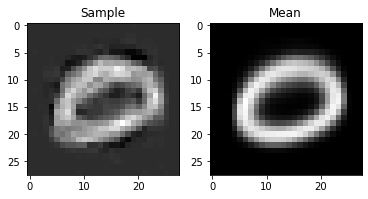

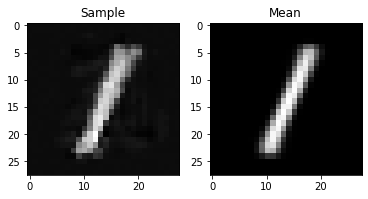

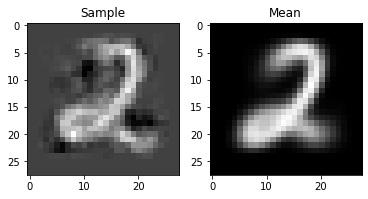

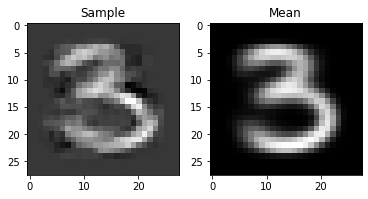

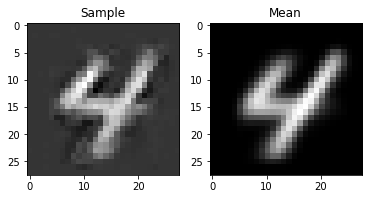

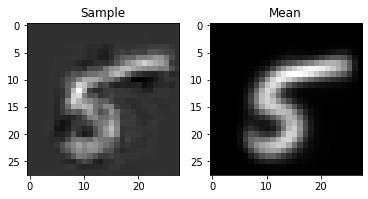

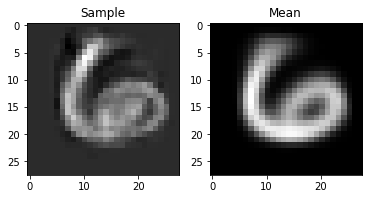

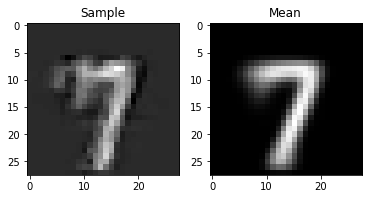

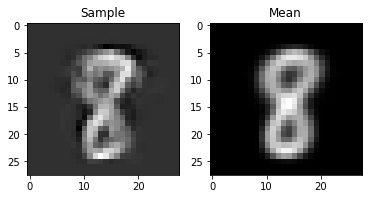

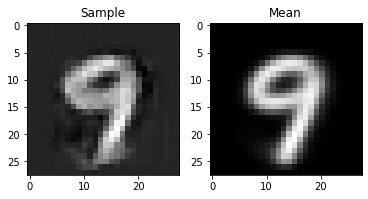

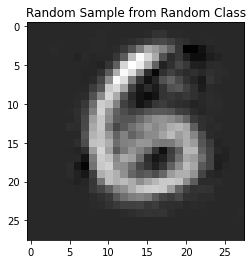

In [24]:
clf = BayesianGMM()
clf.fit(x_train, y_train)

for k in range(clf.K):
  # show one sample for each class
  # also show the mean image learned

  sample, mean = clf.sample_given_y(k)

  plt.subplot(1,2,1)
  plt.imshow(sample, cmap='gray')
  plt.title("Sample")
  plt.subplot(1,2,2)
  plt.imshow(mean, cmap='gray')
  plt.title("Mean")
  plt.show()

# generate a random sample
sample, mean = clf.sample()
plt.imshow(sample, cmap='gray')
plt.title("Random Sample from Random Class")
plt.show()

In [20]:
??clf.sample_given_y